### Phase 4 Project:
###                       Movie Recommendation System

- Student Name : Brian O'Donnell
- Pace: Flex
- Scheduled Project Review Time: January 3rd, 20223 @ 10:00am
- Instructor Name: Abhineet Kulkarni


#### Overview

This project uses the data made available by the 'MovieLens' dataset, which contains 4 CSV files where information such as movie titles, ratings and users are stored. The goal of this project is to create a recommendation system for a new online movie streaming company. We will import the CSV files, inspect and clean the data, perform EDA and then build our models. 

#### Business Understanding

Our stakeholder,"Nu-Stream", is a new start-up company who are attempting to build their own movie streaming service. I have been tasked with creating a recommendation system based off a collection of user movie reviews. Another aspect that will need to be addresses is how to recommend movies for a new user, something that is often called the 'cold-start' problem. 
I believe after the completion of the models our stakeholder will be able to properly suggest appropriate movies to their customers.

### Data Understanding
The 'MovieLens' dataset is provided by the GroupLens research lab at the university of Minnesota. This is a well documented dataset that contains everything from movie titles and ID's, user ID's and ratings, and movie genres. It is a great asset to companies in our position and should have the information we need to build our models.
The method we will be using to achieve our goals is known as User-Based Collaborative Filtering. In which the system predicst the movies that a user might like on the basis of ratings given to that movie by the other users who have similar taste with that of the target user,

To begin, we will start by importing the needed libraries and files that will be used in this project.
***

In [721]:
import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline, KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

%matplotlib inline
movies = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/ratings.csv')
links = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/links.csv')
tags = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/tags.csv')




***
The four files made available by MovieLens are:
-  Movies.csv
-  Ratings.csv
-  Links.csv
-  Tags.csv

We will take a look, one by one, to see what each contains and what is needed for our project. This will also lead to the cleaning phase of the project where we process the data to make it useable for our models.

#### Movies

In [618]:
# A look at the first few rows of the movies file....
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [418]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


***
We see the Movies file contains:
 -  movieId
 -  title
 -  genres
    
While all these columns are very important, we will most likely need some information from the other tables to get everything we need.

#### Ratings

In [419]:
# A look at the ratings file...
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [420]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


***
Ratings file contains:
-  userId
-  movieId
-  rating
-  timestamp

This file not only has the movieId, but the userId and their ratings as well. This is definetely something needed for our models, but it does not have the movie title, and the timestamp column probably is not of much use.

#### Tags

In [421]:
# A look at the tags file...
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [422]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


***
Tags file contains:
-  userId
-  movieId
-  tag
-  timestamp

The only thing this file offers that the others do not is the 'tag' which gives some characteristics of the movie, such as themes or actors.

#### Links

In [423]:
# A look at the links file...
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [424]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


***
The links file contains:
-  movieId
-  imdbId
-  tmdbId

So this file has the corresponding ID's for movies across MovieId, IMDB and TheMoviesDB. This File will most likely not be used.

***
#### Cleaning
We now have a general idea of what the data looks like, we will start by doing a few simple cleaning steps, dropping the 'timestamp' column which has no use for us, and giving the movie year its own column.

In [722]:
# removing timestamp column from both ratings and tags as it does not help us
ratings.drop(columns='timestamp', inplace=True)
tags.drop(columns='timestamp', inplace=True)

#### Year

Now we will create a year column all to its self,and the next few cells will be dedicated to examining this information and seeing if it can be useful to us.

We will follow this process for the majority of columns in our tables.

In [723]:
# We will give year its own column...
movies['Year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)


In [643]:
movies.head()

,movieId,title,genres,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [645]:
# Now that we have the year in its own column, lets make sure it looks right.

movies['Year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

In [688]:
# Check what movie this is that has a range, then we will just set the correct year

movies[movies['Year'] == "2006–2007"]



,movieId,title,genres,Year
9518,171749,Death Note: Desu nôto (2006–2007),(no genres listed),2006–2007


In [724]:
#After IMDB search it appears to be released in 2007

movies['Year'] = movies['Year'].replace("2006–2007","2007")


Another important cleaning step is to make sure there are no missing values, or Nan, which stands for 'Not a number'. We will check the year column for these and how we address the them depends on just how many Nan's there are.

In [651]:
movies[pd.isna(movies['Year'])]

,movieId,title,genres,Year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [725]:
# These will just be dropped since there are so few of them...
movies = movies.dropna(subset=['Year'],how='any')


In [653]:
movies['Year'].describe()

count     9730
unique     106
top       2002
freq       311
Name: Year, dtype: object

In [654]:
movies['Year'].value_counts()

2002    311
2006    295
2001    294
2007    285
2000    283
       ... 
1922      1
1917      1
1902      1
1921      1
1908      1
Name: Year, Length: 106, dtype: int64

In [691]:
# Looking at the year column to see the disribution..
year_count = movies.groupby('Year').count()['title'].reset_index()
year_count.head(10)

,Year,title
0,1902,1
1,1903,1
2,1908,1
3,1915,1
4,1916,4
5,1917,1
6,1919,1
7,1920,2
8,1921,1
9,1922,1


In [692]:
movies['Year'].describe()

count     9730
unique     106
top       2002
freq       311
Name: Year, dtype: object

In [667]:
year_count.describe()

,title
count,106.000000
mean,91.792453
std,102.245709
min,1.000000
25%,16.000000
50%,39.500000
75%,151.500000
max,311.000000


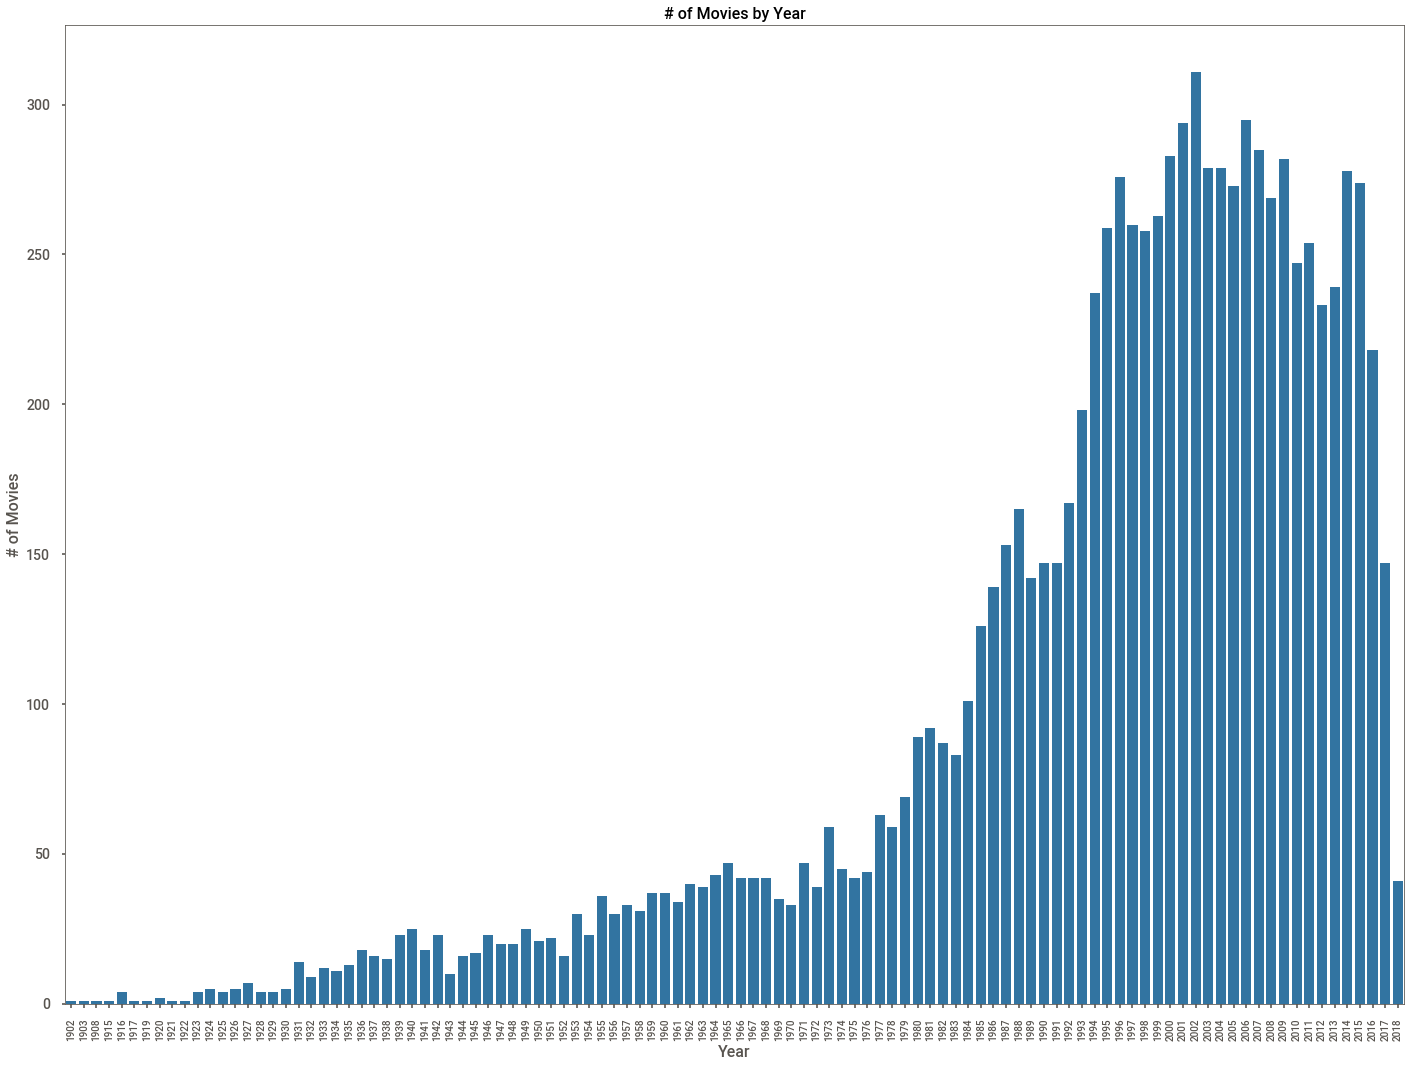

<Figure size 921.6x633.6 with 0 Axes>

In [718]:
 #plot the years - lineplot 

with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(24,18))
    sns.barplot(x='Year', 
                 y = 'title', 
                 data=year_count, 
                 color='tab:blue');
    
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("# of Movies", fontsize=16)
    plt.title("# of Movies by Year",fontsize=16)
    plt.xticks(fontsize=10, rotation=90)
    plt.yticks(fontsize=14)
    ax.grid(False)
    plt.show()
    plt.savefig('years_plot.png')

#### Year Findings

After some minor cleaning our 'Year' column looks useable. We see that there are a total of 106 different years in which a movie was released inside this dataframe, beginning with 1902 ending sometime in 2018. By the steep drop off we can assume it is somewhat early 2018 that they stopped adding movies, so it may not be completely up to date with current trends.


****
Before moving onto the next column there is another issue that we will address now. 



Similar to Nan's, something else that needs to be addressed in order to make clean models is duplicates, which we will check for now...

In [694]:
# Check for duplicates in movieId
print((not movies["movieId"].is_unique))
# Check for duplicates in title
print((not movies["title"].is_unique))

False
True


In [695]:
movies[movies.duplicated(["title"], keep=False)]

,movieId,title,genres,Year
650,838,Emma (1996),Comedy|Drama|Romance,1996
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,1980
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,2002
5601,26958,Emma (1996),Romance,1996
5854,32600,Eros (2004),Drama,2004
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,2005
6932,64997,War of the Worlds (2005),Action|Sci-Fi,2005
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,2002
9135,147002,Eros (2004),Drama|Romance,2004
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller,1980


So after staring at this for a few minutes I see that there are 5 movies that are duplicates:
-  Emma
-  Saturn 3
-  Confessions of a Dangerour Mind
-  Eros
-  War of the Worlds
Obviously the titles are the same, but different movieId, we will replace one Id with the other for each duplicate, and then make sure it changes across all the files.


In [726]:
movie_id_change = {838:26958, 2851:168358, 6003:144606,32600:147002,34048:64997}
movies['movieId'].replace(movie_id_change,inplace=True)
movies = movies.drop_duplicates(subset=["movieId","title"])

ratings['movieId'].replace(movie_id_change,inplace=True)
tags['movieId'].replace(movie_id_change,inplace=True)
links['movieId'].replace(movie_id_change,inplace=True)

In [436]:
# Validation check
print('Is there a duplicate value in a column movieId? Ans:',not movies["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies["title"].is_unique)


Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: False


#### Genres
The genre column needs some work, we will need to preprocess and separate the genres to be able to work with them. Also earlier I noticed a lot of missing values in the genre column, Ill attempt to fix that now.

In [437]:
movies['genres']

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9725, dtype: object

In [727]:
movies['genres'] = movies['genres'].replace('(no genres listed)', np.nan)
print('Number of missing values in genres column:',movies['genres'].isna().sum())


Number of missing values in genres column: 26


In [728]:
movies = movies.dropna(subset=['genres'],how='any')
movies = movies.reset_index(drop=True)

In [729]:
print('Number of missing values in genres column:',movies['genres'].isna().sum())



Number of missing values in genres column: 0


***
So the 26 missing genres has been addressed, we will now use the process of One-Hot-Encoding to create a binary column for each genre.

Next we will:
-  Visualize the genres
-  Extract the genres and encode them using binary to be able to use them in models.

In [730]:
import pandas as pd


# Extract the genre information for each movie
genres = [genre.split('|') for genre in movies['genres']]

# Create a dictionary that maps each genre to a count of the number of movies in that genre
genre_counts = {}
for genre_list in genres:
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Sort the genres by their count, in descending order
sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

#Print the genres and their counts
for genre, count in sorted_genres:
    print(f'{genre}: {count} movies')
    

Drama: 4357 movies
Comedy: 3755 movies
Thriller: 1890 movies
Action: 1826 movies
Romance: 1593 movies
Adventure: 1263 movies
Crime: 1198 movies
Horror: 978 movies
Sci-Fi: 976 movies
Fantasy: 779 movies
Children: 664 movies
Animation: 611 movies
Mystery: 573 movies
Documentary: 440 movies
War: 382 movies
Musical: 334 movies
Western: 167 movies
IMAX: 158 movies
Film-Noir: 87 movies


In [731]:
len(genres)
for x in genres:
    movies[x] = 0
for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        movies[x][i]=1
        
#dropping the genres column as it's a no longer required
movies.drop(columns='genres', inplace=True)
movies.sort_index(inplace=True)
movies


<ipython-input-731-358e6ae71e80>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[x][i]=1


,movieId,title,Year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),1995,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9694,193581,Black Butler: Book of the Atlantic (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9695,193583,No Game No Life: Zero (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9696,193585,Flint (2017),2017,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9697,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Animation             611
Children              664
Comedy               3755
Fantasy               779
Romance              1593
Drama                4357
Action               1826
Crime                1198
Thriller             1890
Horror                978
Mystery               573
Sci-Fi                976
War                   382
Musical               334
Documentary           440
IMAX                  158
Western               167
Film-Noir              87


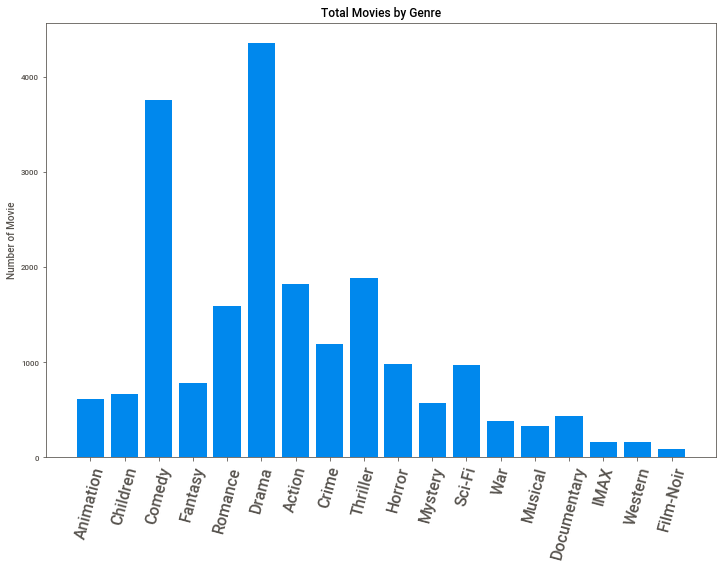

In [733]:
# plotting genres popularity
x = {}
for i in movies.columns[4:23]:
    x[i] = movies[i].sum()
    print(f"{i:<15}{x[i]:>10}")

plt.figure(figsize=(12,8))
plt.bar(height = x.values(), x=x.keys())
plt.xticks(rotation=75, ha='center', fontsize = 16)
plt.ylabel('Number of Movie')
plt.title('Total Movies by Genre')
plt.savefig('genre.png')
plt.show()

***

### Ratings

We will now try to find out what each movies average rating is and more importantly, how many ratings each movie has. If a movie has only 2 reviews but they are both 5 stars then that could create an imbalnce in the model output, we want to make sure the movies have a minimum amount of ratings.

In [464]:
#Finding out the average rating per movie and more importantly how many ratings they have...
avg_rating = ratings.groupby('movieId').rating.mean().rename('avg_rating')
num_rating = ratings.groupby('movieId').userId.count().rename('num_rating')
print(avg_rating.head())
print(num_rating.head())

movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: avg_rating, dtype: float64
movieId
1    215
2    110
3     52
4      7
5     49
Name: num_rating, dtype: int64


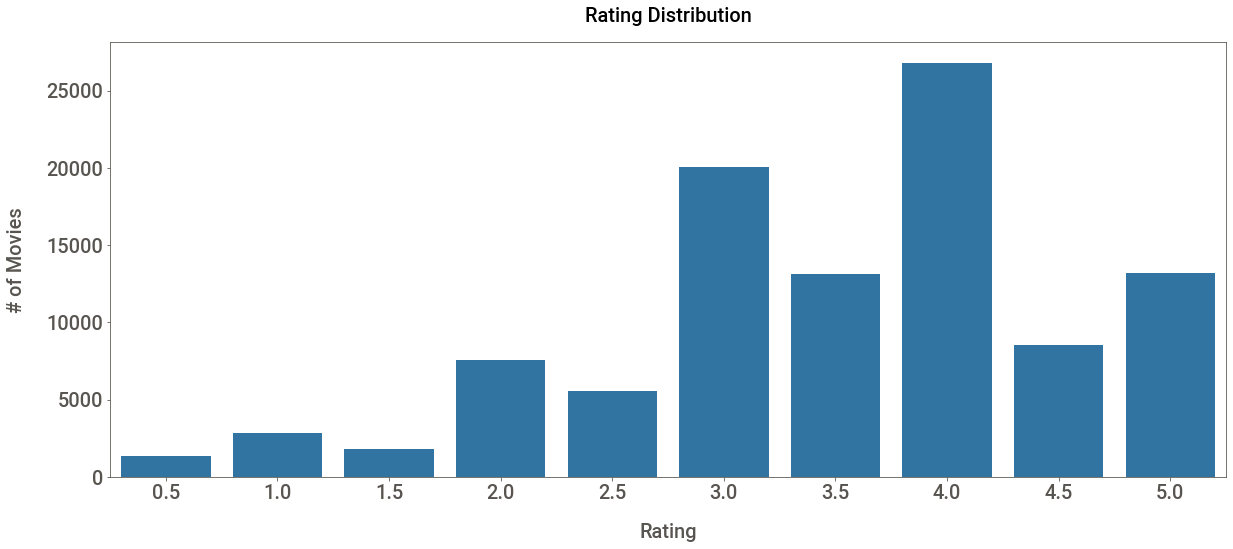

In [738]:
# plot number of ratings

fig, ax = plt.subplots(figsize=(20,8))

sns.countplot(x='rating',
              data=ratings, 
              color='tab:blue');

plt.title("Rating Distribution",fontsize=20, pad=20)
plt.xlabel("Rating", fontsize=20, labelpad=20)
plt.ylabel("# of Movies", fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.savefig('ratings.png')
plt.show()

***

The majority of reviews look like they fall on the top half of the 0.5-5 rating spectrum. More specifically between 3.0-4.0.
***
### Creating DataFrames
Now that we have looked into our files, seen the dataframes and cleaned them to our satisfaction we will begin creating some final datasets.
These will be at our disposal for user-item matrices for our models. 

In [465]:
# Finally time to merge tables now that it looks like most obstacles have been cleaned up. 
movies = pd.merge(movies, avg_rating, how='left', on='movieId')
movies = pd.merge(movies, num_rating, how='left', on='movieId')
# Also filling in any Nan's with a Zero rating or Zero votes, again helps with modeling
movies['avg_rating'].fillna(0, inplace=True)
movies['num_rating'].fillna(0, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [447]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9699 entries, 0 to 9698
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9699 non-null   int64  
 1   title        9699 non-null   object 
 2   year         9699 non-null   object 
 3   Adventure    9699 non-null   int64  
 4   Animation    9699 non-null   int64  
 5   Children     9699 non-null   int64  
 6   Comedy       9699 non-null   int64  
 7   Fantasy      9699 non-null   int64  
 8   Romance      9699 non-null   int64  
 9   Drama        9699 non-null   int64  
 10  Action       9699 non-null   int64  
 11  Crime        9699 non-null   int64  
 12  Thriller     9699 non-null   int64  
 13  Horror       9699 non-null   int64  
 14  Mystery      9699 non-null   int64  
 15  Sci-Fi       9699 non-null   int64  
 16  War          9699 non-null   int64  
 17  Musical      9699 non-null   int64  
 18  Documentary  9699 non-null   int64  
 19  IMAX  

### Final Dataframes..

We merged one dataframe after our cleaning and added some new features, and in the next few cells I will create some more. Not all of these tables will be used but I am trying to create different sets of 'User-Item' matrices that may be useful for our models. 

In [466]:
# Another merge to get userId in there....
# This dataframe will have all the needed attributes, movies, users, genres, reviews...
movie_and_ratings = pd.merge(ratings, movies, how='left', on = 'movieId')
movie_and_ratings.rename(columns={'rating_x': 'rating', 
                                   'rating_y': 'RatingsCount'}, 
                          inplace=True)

In [450]:
movie_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       100836 non-null  int64  
 1   movieId      100836 non-null  int64  
 2   rating       100836 non-null  float64
 3   title        100781 non-null  object 
 4   year         100781 non-null  object 
 5   Adventure    100781 non-null  float64
 6   Animation    100781 non-null  float64
 7   Children     100781 non-null  float64
 8   Comedy       100781 non-null  float64
 9   Fantasy      100781 non-null  float64
 10  Romance      100781 non-null  float64
 11  Drama        100781 non-null  float64
 12  Action       100781 non-null  float64
 13  Crime        100781 non-null  float64
 14  Thriller     100781 non-null  float64
 15  Horror       100781 non-null  float64
 16  Mystery      100781 non-null  float64
 17  Sci-Fi       100781 non-null  float64
 18  War          100781 non-

In [467]:
# sort by ratings counts 

movie_and_ratings_sorted = (
    movie_and_ratings
    .sort_values(by='num_rating', ascending=False)
    .drop_duplicates('movieId')
    )

movie_and_ratings_sorted

,userId,movieId,rating,title,year,Adventure,Animation,Children,Comedy,Fantasy,...,avg_rating_x,num_rating_x,avg_rating_y,num_rating_y,avg_rating_x,num_rating_x,avg_rating_y,num_rating_y,avg_rating,num_rating
76283,480,356,5.0,Forrest Gump (1994),1994,0.0,0.0,0.0,1.0,0.0,...,4.164134,329.0,4.164134,329.0,4.164134,329.0,4.164134,329.0,4.164134,329.0
3909,24,318,4.5,"Shawshank Redemption, The (1994)",1994,0.0,0.0,0.0,0.0,0.0,...,4.429022,317.0,4.429022,317.0,4.429022,317.0,4.429022,317.0,4.429022,317.0
18412,117,296,4.0,Pulp Fiction (1994),1994,0.0,0.0,0.0,1.0,0.0,...,4.197068,307.0,4.197068,307.0,4.197068,307.0,4.197068,307.0,4.197068,307.0
50481,326,593,4.5,"Silence of the Lambs, The (1991)",1991,0.0,0.0,0.0,0.0,0.0,...,4.161290,279.0,4.161290,279.0,4.161290,279.0,4.161290,279.0,4.161290,279.0
23520,160,2571,4.0,"Matrix, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,...,4.192446,278.0,4.192446,278.0,4.192446,278.0,4.192446,278.0,4.192446,278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88136,567,156605,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92128,596,141131,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92154,596,181719,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95014,599,132084,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [468]:
# Try to get rid of the Nan...
movie_and_ratings_sorted['avg_rating'].fillna(0, inplace=True)
movie_and_ratings_sorted['num_rating'].fillna(0, inplace=True)
movie_and_ratings_sorted

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,userId,movieId,rating,title,year,Adventure,Animation,Children,Comedy,Fantasy,...,avg_rating_x,num_rating_x,avg_rating_y,num_rating_y,avg_rating_x,num_rating_x,avg_rating_y,num_rating_y,avg_rating,num_rating
76283,480,356,5.0,Forrest Gump (1994),1994,0.0,0.0,0.0,1.0,0.0,...,4.164134,329.0,4.164134,329.0,4.164134,329.0,4.164134,329.0,4.164134,329.0
3909,24,318,4.5,"Shawshank Redemption, The (1994)",1994,0.0,0.0,0.0,0.0,0.0,...,4.429022,317.0,4.429022,317.0,4.429022,317.0,4.429022,317.0,4.429022,317.0
18412,117,296,4.0,Pulp Fiction (1994),1994,0.0,0.0,0.0,1.0,0.0,...,4.197068,307.0,4.197068,307.0,4.197068,307.0,4.197068,307.0,4.197068,307.0
50481,326,593,4.5,"Silence of the Lambs, The (1991)",1991,0.0,0.0,0.0,0.0,0.0,...,4.161290,279.0,4.161290,279.0,4.161290,279.0,4.161290,279.0,4.161290,279.0
23520,160,2571,4.0,"Matrix, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,...,4.192446,278.0,4.192446,278.0,4.192446,278.0,4.192446,278.0,4.192446,278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88136,567,156605,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92128,596,141131,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92154,596,181719,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95014,599,132084,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Number of Reviews
So an issue we have to address is the fact that some movies may have a 5 star rating, but only have a handful of reviews. We want those movies to have less influence than movies with several reviews otherwise the model may create poor recommendations of movies that have few reviews.

In [717]:
# Setting a minimum number of reviews
minimum_num_ratings = 100
movie_and_ratings=movie_and_ratings[movie_and_ratings['num_rating']>minimum_num_ratings].sort_values(by=['avg_rating'], ascending=False)

In [470]:
# merging ratings and movies data
matrix_df = pd.merge(ratings, movies, how='left', on = 'movieId')
# creating matrix
movie_user_matrix = matrix_df.pivot_table(index='userId', columns='title', values='avg_rating')
movie_user_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.134615,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.863636,2.770833,NaN,NaN,NaN


In [455]:
movie_user_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 1 to 610
Columns: 9681 entries, '71 (2014) to À nous la liberté (Freedom for Us) (1931)
dtypes: float64(9681)
memory usage: 45.1 MB


#### Colloborative Filtering with User-Item Matrix
These last tables represent our user-item matrices. This is used in our recommendation system to represent the interactions between users and items, where each row is a userId and each column is an item, which in our case is a movie. 

The reason there are some Nan's is becasue obviously not every user has seen much less rated every movie.

****

### First Models

To begin, in the context of the Surprise library, the 'build_full_trainset' function is used to create a Trainset object from a Dataset object. A Trainset object is a special type of dataset object that is used to train a recommendation model in the Surprise library. It contains the ratings data, as well as additional information such as the indices of the users and items, the rating scale, and the number of ratings. And from the Trainset we can create the Testset and therefore are able to train the model and make predictions in the user-item matrix.

In [832]:
# read in values as Surprise dataset
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(movie_and_ratings[['userId', 'title', 'rating']], 
    reader)

#generating a trainset
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()
print('Number of users: ', dataset.n_users,)
print('Number of items: ', dataset.n_items)
print('Number of ratings: ',dataset.n_ratings)

Number of users:  610
Number of items:  2121
Number of ratings:  79640


***
### SVD

Singular value decomposition (SVD) is a matrix factorization technique that can be used to decompose a matrix into its constituent parts. In the context of recommendation systems, SVD can be used to decompose a user-item matrix into the product of three matrices: a user matrix, a diagonal matrix of singular values, and an item matrix. These matrices can then be used to make recommendations to users.

***

In [480]:
#Instantiate the SVD model
svd = SVD()

In [481]:
# Returning 5 cross-validated iterations 
cv_svd = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8474  0.8441  0.8495  0.8491  0.8573  0.8495  0.0044  
MAE (testset)     0.6495  0.6486  0.6511  0.6499  0.6568  0.6512  0.0029  
Fit time          3.47    3.46    3.39    3.54    3.41    3.45    0.05    
Test time         0.08    0.09    0.08    0.08    0.09    0.08    0.01    



#### SVD Grid Search 
We ran 5 iterations of the SVD algo and got decent returns for our metrics, at least to start with. We will now run a grid search in an attempt to find the best parameter for the SVD algorithm to get our error scores even lower while trying to avoid overfitting.

In [482]:
# From lesson *
# Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
params = {'n_factors': [20, 50, 100],
          'n_epochs':[5,10],
          'lr_all':[0.002, 0.005],
         'reg_all': [0.02, 0.1, 0.5]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

# n_factors = latent/underlying factors-higher can improve but also overfit
# n_epochs = iterations, higher can learn more but also overfit

In [483]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8527852887315772, 'mae': 0.6549498875244633}
{'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}}


In [484]:
# FINAL SVD MODEL

# This cell takes longer to run because the parameters are even more specific, but does yield lower errors..
#Prarameter space
# run time approximately 10 min
svd_param_grid = {'n_epochs': [20, 25, 30, 40, 50],
                  'lr_all': [0.007, 0.009, 0.01, 0.02],
                  'reg_all': [0.02, 0.04, 0.1, 0.2]}

# This will take some time to execute.
gs_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_svd.fit(data)


In [485]:
print('Best value for SVD  -RMSE:', round(gs_svd.best_score['rmse'], 4), '; MAE:', round(gs_svd.best_score['mae'], 4))
print('Optimal params RMSE =', gs_svd.best_params['rmse'])
print('optimal params MAE =', gs_svd.best_params['mae'])

Best value for SVD  -RMSE: 0.8228 ; MAE: 0.63
Optimal params RMSE = {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}
optimal params MAE = {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


#### Final SVD Model:
Final RMSE is a respectable 0.82, which we can look at as the average predicted rating being .82 stars away from the actual rating.
***

### Some Information On the Metrics...
#### RMSE
The root mean squared error (RMSE) is a measure of the accuracy of a prediction model. 

In a recommendation system, the RMSE score is calculated by taking the square root of the mean squared error between the predicted ratings and the actual ratings in the test set. The mean squared error is calculated by taking the sum of the squared differences between the predicted and actual ratings, and dividing by the number of ratings in the test set.

A lower RMSE score indicates that the model is making more accurate predictions, while a higher RMSE score indicates that the model is making less accurate predictions.

#### MAE

In a recommendation system, the MAE is calculated by taking the absolute value of the difference between the predicted ratings and the actual ratings in the test set, and averaging these differences over the number of ratings in the test set.

Like the root mean squared error (RMSE), the MAE is a measure of the average error of the model's predictions. However, unlike the RMSE, the MAE does not square the errors before averaging them, which means that it is less sensitive to large errors and may be more appropriate for data with a large number of outliers. And again,the lower the score the better.

***
### KNN
In addition to using SVD, we will also run and compare some KNN algo's.  In a recommendation system, KNN works by finding the K nearest neighbors of a user or item, and using these neighbors to make recommendations.

***

In [486]:
cv_knn_basic = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_means = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_z = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_baseline = cross_validate(KNNBaseline(), data, cv=5, n_jobs=5, verbose=True)




Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9046  0.9030  0.8941  0.9119  0.9038  0.9035  0.0057  
MAE (testset)     0.6940  0.6896  0.6891  0.7008  0.6954  0.6938  0.0043  
Fit time          0.06    0.06    0.06    0.05    0.07    0.06    0.01    
Test time         0.88    0.90    0.88    0.84    0.86    0.87    0.02    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8445  0.8544  0.8624  0.8528  0.8510  0.8530  0.0058  
MAE (testset)     0.6471  0.6529  0.6574  0.6535  0.6513  0.6524  0.0033  
Fit time          0.06    0.06    0.08    0.08    0.08    0.07    0.01    
Test time         0.98    0.97    0.96    0.95    0.94    0.96    0.02    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [741]:
# Printing out the results for the KNN algorithms
print('Evaluation Results:')
print('Algoritm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(cv_knn_basic['test_rmse'].mean(), 4), '\t', round(cv_knn_basic['test_mae'].mean(), 4))
print('KNN Means', '\t', round(cv_knn_means['test_rmse'].mean(), 4), '\t\t', round(cv_knn_means['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(cv_knn_z['test_rmse'].mean(), 4), '\t', round(cv_knn_z['test_mae'].mean(), 4)),
print('KNN Baseline', '\t', round(cv_knn_baseline['test_rmse'].mean(), 4), '\t', round(cv_knn_baseline['test_mae'].mean(), 4))


print()


Evaluation Results:
Algoritm	 RMSE		 MAE

KNN Basic 	 0.9035 	 0.6938
KNN Means 	 0.853 		 0.6524
KNN ZScore 	 0.8514 	 0.6478
KNN Baseline 	 0.8402 	 0.6423



#### KNN Grid Search
After running four different KNN algos, with 5 iterations each we see some baseline scores that look decent. Now just as we ran a grid search with our SVD model to find the optimal parameters, we will do the same with the KNN Baseline model which looked like it had the best results of the four KNN's that we ran.

In [488]:
#k-Nearest Neighbor Grid Search
# Run time appox 10-15 min
#Collaborative filtering algorithm that uses Baseline rating
param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
              'sim_options': {'user_based': [True, False]},\
              'bsl_options': {'method': ['als', 'sgd']}}

gs_knnb = GridSearchCV(KNNBaseline, 
                       param_grid, 
                       measures=['rmse', 'mae'], 
                       cv=5)

gs_knnb.fit(data)

print(gs_knnb.best_score['rmse'])
print(gs_knnb.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

In [489]:
# FINAL KNN MODEL

print('Best value for K-NN GridSearch  -RMSE:', round(gs_knnb.best_score['rmse'], 4), '; MAE:', round(gs_knnb.best_score['mae'], 4))
print('Optimal params RMSE =', gs_knnb.best_params['rmse'])
print('optimal params MAE =', gs_knnb.best_params['mae'])

Best value for K-NN GridSearch  -RMSE: 0.8369 ; MAE: 0.64
Optimal params RMSE = {'k': 90, 'sim_options': {'user_based': False}, 'bsl_options': {'method': 'sgd'}}
optimal params MAE = {'k': 90, 'sim_options': {'user_based': False}, 'bsl_options': {'method': 'als'}}


****
### Visualizing our Scores:
We ran some intial iterations on our 2 algos and followed those up with a grid search, we will see if we can visualize all these scores to get a better sense of them.

The steps to do this will be as follows:
-  Create a dataframe for the scores of both the KNN and SVD algorithm
-  Merge those 2 dataframes 
-  Plot a bar chart to show comparison

In [793]:
score_visuals= pd.DataFrame(gs_knnb.best_score, index = param_grid)
score_visuals

,rmse,mae
k,0.836913,0.639995
sim_options,0.836913,0.639995
bsl_options,0.836913,0.639995


In [811]:
svd_score = pd.DataFrame(gs_svd.best_score, index = param_grid)
svd_score

,rmse,mae
k,0.822801,0.629953
sim_options,0.822801,0.629953
bsl_options,0.822801,0.629953


In [829]:
visual_df = pd.concat([svd_score, score_visuals], axis=0)
visual_df.index = ['SVD_Fold1','SVD_Fold2','SVD_Fold3','KNN_Fold1','KNN_Fold2','KNN_Fold3']
visual_df


,rmse,mae
SVD_Fold1,0.822801,0.629953
SVD_Fold2,0.822801,0.629953
SVD_Fold3,0.822801,0.629953
KNN_Fold1,0.836913,0.639995
KNN_Fold2,0.836913,0.639995
KNN_Fold3,0.836913,0.639995


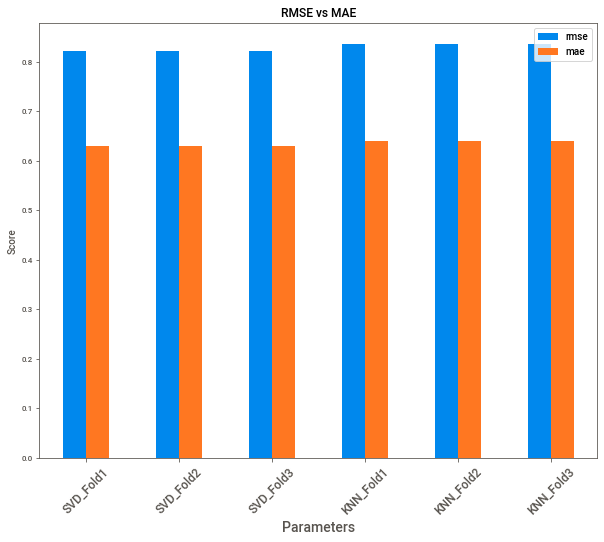

In [831]:
visual_df.plot(kind='bar', figsize=(10,8))
plt.title('RMSE vs MAE')
plt.xlabel('Parameters', fontsize =(14))
plt.xticks(rotation = 45, fontsize = (12))
plt.ylabel('Score')
plt.savefig('scores.png')

In [836]:
print('GridSearch Results:')
print('Algoritm\t RMSE\t\t MAE')
print()
print('KNN Baselie', '\t', round(gs_knnb.best_score['rmse'].mean(), 4), '\t', round(gs_knnb.best_score['mae'].mean(), 4))
print('SVD', '\t\t', round(gs_svd.best_score['rmse'].mean(), 4), '\t', round(gs_svd.best_score['mae'].mean(), 4))



GridSearch Results:
Algoritm	 RMSE		 MAE

KNN Baselie 	 0.8369 	 0.64
SVD 		 0.8228 	 0.63


### Visual Results:
We see that the differences created by the GridSearch are so miniscule they are hardly noticeable between the the 2 algorithms. Therefore we will use the '.best_score' attribute to fit into our models and create 2 recommendation functions, one for each algorithm and compare the results.

### Predictions 
Now that we have our final KNN and SVD algorithms in place we will use the .fit attribute and then plug them into the 'get_top_n' function provided in the Surprise library documentation. This will return the top 5 items with the highest rating prediction for each user. We will try this on both our algorithms, starting with KNN.

In [742]:
final_knn_model = KNNBaseline(k=90, sim_options={'name': 'pearson_baseline','user_based':False},
                              bsl_options={'method':'sgd'})
final_knn_model.fit(dataset)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [491]:
predictions_k = final_knn_model.test(testset)

### KNN Recommendation System:

In [492]:
from collections import defaultdict


def get_top_n_k(predictions_k, minimum_num_ratings= 50, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # Map the predictions to each user
    top_n_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions_k:
        top_n_k[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones
    for uid, user_ratings in top_n_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n_k[uid] = user_ratings[:n]

    return top_n_k

top_n_k = get_top_n_k(predictions_k, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n_k.items():
    print(uid, [iid for (iid, _) in user_ratings])

195 ['Lawrence of Arabia (1962)', 'There Will Be Blood (2007)', "Once Upon a Time in the West (C'era una volta il West) (1968)", 'Ran (1985)', "Guess Who's Coming to Dinner (1967)"]
90 ['Paths of Glory (1957)', 'Streetcar Named Desire, A (1951)', 'Celebration, The (Festen) (1998)', 'Hustler, The (1961)', 'Philadelphia Story, The (1940)']
603 ['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Cool Hand Luke (1967)', 'Hustler, The (1961)', "No Man's Land (2001)", 'Doctor Zhivago (1965)']
290 ['Streetcar Named Desire, A (1951)', "Guess Who's Coming to Dinner (1967)", 'Paths of Glory (1957)', 'Touch of Evil (1958)', '12 Angry Men (1957)']
474 ['In Bruges (2008)', 'Dark Knight, The (2008)', 'How to Train Your Dragon (2010)', 'Spotlight (2015)', 'Snatch (2000)']
391 ['Touch of Evil (1958)', 'Great Escape, The (1963)', 'Cool Hand Luke (1967)', 'Ghost in the Shell (Kôkaku kidôtai) (1995)', 'Hustler, The (1961)']
74 ['Streetcar Named Desire, A (1951)', 'Lawrence of

In [503]:
# Get the top recommendations for specific user....
user_id = 608
recommendations = get_top_n_k(predictions_k,minimum_num_ratings=100, n=5)[user_id]

# Print the recommended movie IDs and predicted ratings
print([(iid, rating) for (iid, rating) in recommendations])



[('Dark Knight, The (2008)', 4.215843395524766), ('Prisoners (2013)', 4.212079225026457), ('Spotlight (2015)', 4.193783809287072), ('Departed, The (2006)', 4.1654399244949305), ('There Will Be Blood (2007)', 4.147380483286304)]


#### KNN Recommendation System Results:
So the function ran and created a list of users and estimated ratings like we hoped. To make a bit more sense of it in the cell above I retrieved the recommendations of a specific user. Those results looked very appropriate!

### SVD Model

Just like with the KNN model we are going to fit our chosen SVD parameters to the dataset to allow us to make predictions in our function

In [496]:
# From our grid search:
#Best value for SVD  -RMSE: 0.8511 ; MAE: 0.652
#Optimal params RMSE = {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}
#optimal params MAE = {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}

svd_algo = SVD(n_epochs=50, lr_all=0.01, reg_all=0.1)
svd_algo.fit(dataset)
svd_predictions = svd_algo.test(testset)

# SVD Recommendation Function 
The same function with SVD algo. 

In [497]:
from collections import defaultdict


def get_top_n(svd__predictions, minimum_num_ratings= 50, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # Map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in svd_predictions:
        top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(svd_predictions, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

195 ['Grand Day Out with Wallace and Gromit, A (1989)', 'Battlestar Galactica (2003)', 'Touch of Evil (1958)', 'His Girl Friday (1940)', 'Wallace & Gromit: The Best of Aardman Animation (1996)']
90 ['Grand Day Out with Wallace and Gromit, A (1989)', 'Paths of Glory (1957)', 'Yojimbo (1961)', "Guess Who's Coming to Dinner (1967)", 'Ran (1985)']
603 ['Hustler, The (1961)', 'Yojimbo (1961)', 'Maltese Falcon, The (a.k.a. Dangerous Female) (1931)', 'Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948)', '12 Angry Men (1957)']
290 ["Guess Who's Coming to Dinner (1967)", 'Paths of Glory (1957)', 'Streetcar Named Desire, A (1951)', 'Ran (1985)', 'Hustler, The (1961)']
474 ['Celebration, The (Festen) (1998)', 'Spotlight (2015)', 'Snatch (2000)', 'Logan (2017)', 'Dallas Buyers Club (2013)']
391 ['Spirited Away (Sen to Chihiro no kamikakushi) (2001)', 'Cool Hand Luke (1967)', 'My Fair Lady (1964)', "Guess Who's Coming to Dinner (1967)", 'Great Escap

In [516]:
# Get the top recommendations for specific user....
user_id = 608
recommendations = get_top_n(svd_predictions,minimum_num_ratings=100, n=5)[user_id]

# Print the recommended movie IDs and predicted ratings
print([(iid, rating) for (iid, rating) in recommendations])



[('Touch of Evil (1958)', 4.159065804263628), ("Guess Who's Coming to Dinner (1967)", 4.123940190684259), ('Secrets & Lies (1996)', 4.123259228556291), ('Celebration, The (Festen) (1998)', 4.100122831410601), ('Battlestar Galactica (2003)', 4.086744365209958)]


### SVD Results:
So after running the function, I used the three previous cells to get the top 5 recommendations for a specific user. The results seems ok, most of the movies are of similar rating but the genres are more spread out. 

***
### Cold Start Problem

While the prediction and functions are producing some good results, there is one issue it does not address. It is something known as the 'cold-start' problem, where our model can not predict movies for a new user since it has not gathered any data from that person yet. 

In [604]:
def get_recommendations_for_new_user(new_user, movie_user_matrix, svd_algo, N=5):
    """Return recommendations for a new user using a collaborative filtering recommendation method.
    
    Args:
        new_user (pandas Series): The new user's ratings for a subset of movies.
        movie_user_matrix (pandas DataFrame): The movie-user matrix containing the ratings of all users.
        svd_algo (surprise.prediction_algorithms.matrix_factorization.SVD): The trained SVD algorithm.
        N (int): The number of recommendations to return.
        
    Returns:
        list: A list of tuples containing the recommended movie titles and predicted ratings.
    """
    # Create a temporary dataset
    temp_df = pd.concat([movie_user_matrix, new_user], axis=0)
    temp_df.fillna(0, inplace=True)
    temp_matrix = temp_df.values
    
    # Create a trainset from the temporary matrix
    trainset_temp = data.build_full_trainset()
    
    # Train the SVD algorithm on the temporary trainset
    svd_algo.fit(trainset_temp)
    
    # Get the predicted ratings for the new user
    new_user_predictions = svd_algo.test(trainset_temp.build_anti_testset())
    
    # Sort the predictions by predicted rating in descending order
    new_user_predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Return the top N movie titles and predicted ratings
    return [(prediction.iid, prediction.est) for prediction in new_user_predictions[:N]]


In [605]:
# Creating a new user with a few movie and ratings to add in...

new_user_ratings = pd.Series({'Toy Story (1995)': 5, 'Jumanji (1995)': 4, 'Grumpier Old Men (1995)': 2})
recommendations = get_recommendations_for_new_user(new_user_ratings, movie_user_matrix, svd_algo, N=5)


In [606]:
# Seeing the recommendations for our new user...

for recommendation in recommendations:
    movie_title, prediction = recommendation
    print(f'Movie: {movie_title}, Predicted Rating: {prediction:.1f}')


Movie: Secrets & Lies (1996), Predicted Rating: 5.0
Movie: Guess Who's Coming to Dinner (1967), Predicted Rating: 5.0
Movie: Paths of Glory (1957), Predicted Rating: 5.0
Movie: Celebration, The (Festen) (1998), Predicted Rating: 5.0
Movie: Ran (1985), Predicted Rating: 5.0


### Conclusion:

We began by inspecting and cleaning the data and then proceeded to train our algorithms.
We got some very good results, especially with our KNN based model. Our 'cold-start' model is a work in progress but very promising. 

### Final Evaluation For our Stakeholder:

-  Use the KNN model to launch
-  Continue to test and re-run the models every few months
-  Continue to use the Cold-Start engine to gain better insight into recommendation for the customers
- Consider weighting movies based on genre or year released, several of these movies being returned are classics, but quite old

Appendix/References:
-  Year Extraction:
https://stackoverflow.com/questions/62646601/how-to-extract-user-ratings-from-a-movie-dataset
-Surpirse Library
  -Functions/algos etc
https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=new%20user#how-to-get-the-top-n-recommendations-for-each-user
- Cold Start function ideas:
https://robban112.github.io/images/Kandidatexamensrapport.pdf
